In [3]:
import numpy as np
import torch
from scipy.stats import pearsonr
import NPI
from npi_enhanced import train_with_masking, train_with_snr_weights, train_multi_resolution, compute_confidence_weighted_EC, map_coarse_to_fine_EC
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def flat_without_diagonal(matrix):
    n = matrix.shape[0]
    return np.array([matrix[i][j] for i in range(n) for j in list(range(i)) + list(range(i + 1, n))])

In [5]:
batch_size = 64
train_set_proportion = 0.8
ROI_num = 20
using_steps = 3

##1. Baseline (Uniform SNR, No Smoothing)

In [7]:
signals = np.loadtxt('/content/baseline_seed00_signal.txt')
SC = np.loadtxt('/content/baseline_seed00_SC.txt')
real_EC = np.loadtxt('/content/baseline_seed00_real_EC.txt')

In [8]:
inputs, targets = NPI.multi2one(signals, steps=using_steps)

ANN_baseline = NPI.ANN_MLP(
    input_dim=using_steps * ROI_num,
    hidden_dim=2 * ROI_num,
    latent_dim=int(0.8 * ROI_num),
    output_dim=ROI_num
)

ANN_baseline, train_loss_base, test_loss_base = NPI.train_NN(
    ANN_baseline, inputs, targets, batch_size, train_set_proportion,
    num_epochs=100, lr=2.5e-4, l2=5e-5
)

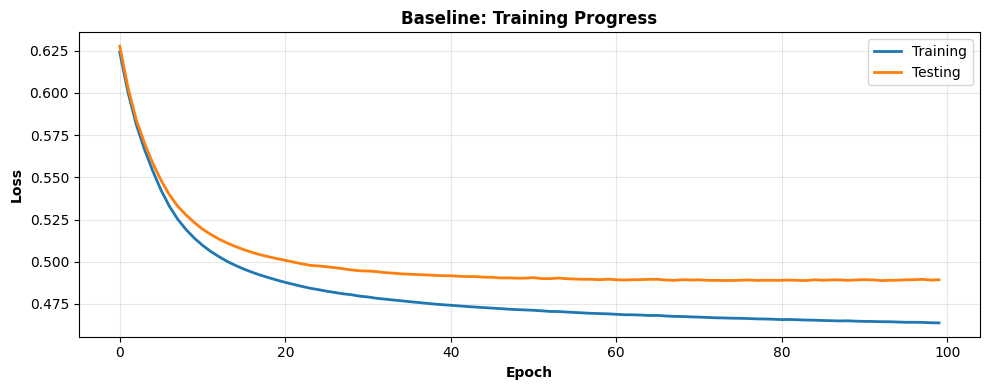

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss_base, label='Training', linewidth=2)
plt.plot(test_loss_base, label='Testing', linewidth=2)
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Baseline: Training Progress', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
NPI_EC_baseline = NPI.model_EC(ANN_baseline, inputs, targets, pert_strength=1.0)
np.fill_diagonal(NPI_EC_baseline, 0)

r_base, p_base = pearsonr(flat_without_diagonal(NPI_EC_baseline), flat_without_diagonal(real_EC))
print(f'Baseline: r = {r_base:.3f}, p = {p_base:.2e}')

Baseline: r = 0.912, p = 2.68e-148


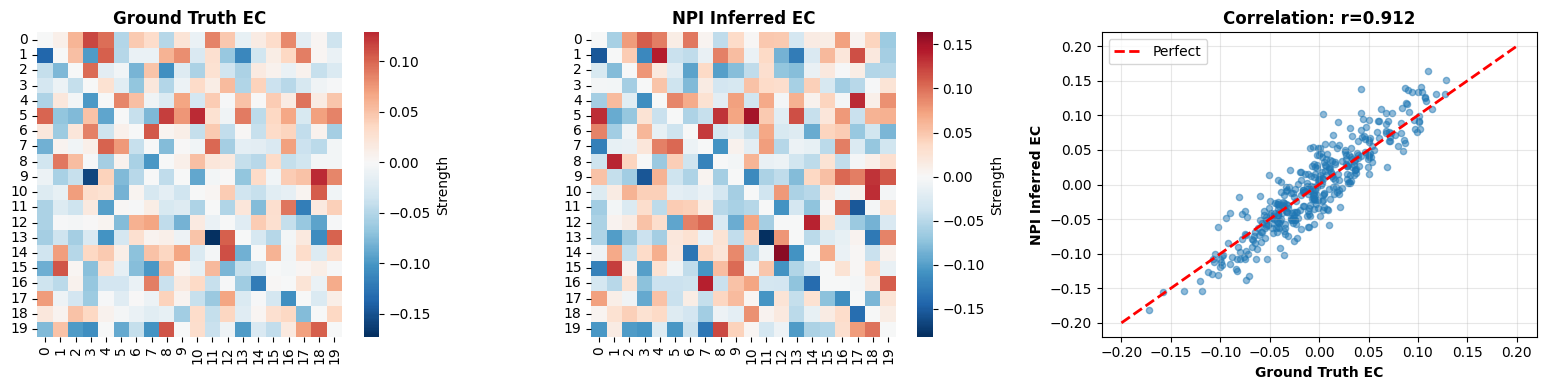

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.heatmap(real_EC, cmap='RdBu_r', center=0, ax=axes[0], square=True, cbar_kws={'label': 'Strength'})
axes[0].set_title('Ground Truth EC', fontweight='bold', fontsize=12)

sns.heatmap(NPI_EC_baseline, cmap='RdBu_r', center=0, ax=axes[1], square=True, cbar_kws={'label': 'Strength'})
axes[1].set_title('NPI Inferred EC', fontweight='bold', fontsize=12)

axes[2].scatter(flat_without_diagonal(real_EC), flat_without_diagonal(NPI_EC_baseline), alpha=0.5, s=20)
axes[2].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2, label='Perfect')
axes[2].set_xlabel('Ground Truth EC', fontweight='bold')
axes[2].set_ylabel('NPI Inferred EC', fontweight='bold')
axes[2].set_title(f'Correlation: r={r_base:.3f}', fontweight='bold', fontsize=12)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

##2. Heterogeneous SNR

In [13]:
signals_hetero = np.loadtxt('/content/hetero_snr_seed01_signal.txt')
real_EC_hetero = np.loadtxt('/content/hetero_snr_seed01_real_EC.txt')
SNR_per_region = np.loadtxt('/content/hetero_snr_seed01_SNR.txt')

inputs_hetero, targets_hetero = NPI.multi2one(signals_hetero, steps=using_steps)
inputs_hetero_tensor = torch.FloatTensor(inputs_hetero)
targets_hetero_tensor = torch.FloatTensor(targets_hetero)

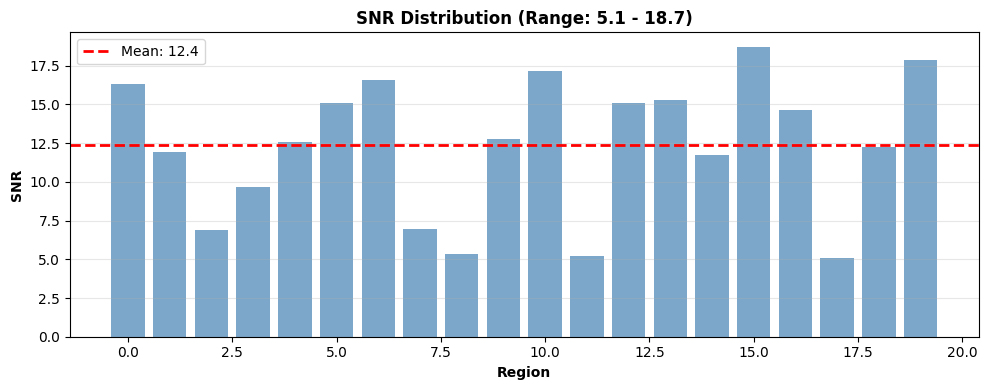

In [14]:
plt.figure(figsize=(10, 4))
bars = plt.bar(range(ROI_num), SNR_per_region, color='steelblue', alpha=0.7)
plt.axhline(y=SNR_per_region.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {SNR_per_region.mean():.1f}')
plt.xlabel('Region', fontweight='bold')
plt.ylabel('SNR', fontweight='bold')
plt.title(f'SNR Distribution (Range: {SNR_per_region.min():.1f} - {SNR_per_region.max():.1f})', fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##2.1 Standard Training (No SNR weighting)

In [15]:
ANN_hetero_std = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_hetero_std, _, _ = NPI.train_NN(ANN_hetero_std, inputs_hetero, targets_hetero, batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5)

EC_hetero_std = NPI.model_EC(ANN_hetero_std, inputs_hetero, targets_hetero, pert_strength=1.0)
np.fill_diagonal(EC_hetero_std, 0)
r_std, _ = pearsonr(flat_without_diagonal(EC_hetero_std), flat_without_diagonal(real_EC_hetero))
print(f'Hetero SNR (Standard): r = {r_std:.3f}')

Hetero SNR (Standard): r = 0.886


### 2.2 SNR-Weighted Training

In [16]:
ANN_hetero_weighted = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_hetero_weighted, _, _ = train_with_snr_weights(
    ANN_hetero_weighted, inputs_hetero_tensor, targets_hetero_tensor, SNR_per_region,
    batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5,
    weight_strategy='log', weight_strength=0.3
)

EC_hetero_weighted = NPI.model_EC(ANN_hetero_weighted, inputs_hetero_tensor, targets_hetero_tensor, pert_strength=1.0)
np.fill_diagonal(EC_hetero_weighted, 0)
r_weighted, _ = pearsonr(flat_without_diagonal(EC_hetero_weighted), flat_without_diagonal(real_EC_hetero))
print(f'Hetero SNR (Weighted log_0.3): r = {r_weighted:.3f}')
print(f'Improvement: {r_weighted - r_std:+.3f}')

/content/npi_enhanced.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(input_X[:int(train_set_proportion * input_X.shape[0])], dtype=torch.float).to(device)
/content/npi_enhanced.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(target_Y[:int(train_set_proportion * target_Y.shape[0])], dtype=torch.float).to(device)
/content/npi_enhanced.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(input_X[int(train_set_proportion * input_X.shape[0]):], dtype

Hetero SNR (Weighted log_0.3): r = 0.878
Improvement: -0.008


/content/NPI.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unperturbed_output = model(torch.tensor(input_X, dtype = torch.float).to(device)).detach().cpu().numpy()
/content/NPI.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_output = model(torch.tensor(input_X + perturbation.flatten(), dtype = torch.float).to(device)).detach().cpu().numpy()


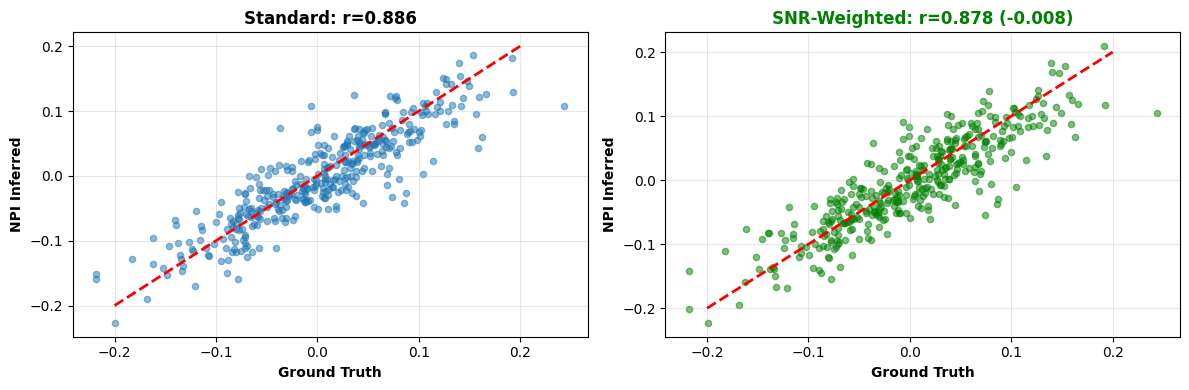

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(flat_without_diagonal(real_EC_hetero), flat_without_diagonal(EC_hetero_std), alpha=0.5, s=20)
axes[0].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[0].set_xlabel('Ground Truth', fontweight='bold')
axes[0].set_ylabel('NPI Inferred', fontweight='bold')
axes[0].set_title(f'Standard: r={r_std:.3f}', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(flat_without_diagonal(real_EC_hetero), flat_without_diagonal(EC_hetero_weighted), alpha=0.5, s=20, color='green')
axes[1].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[1].set_xlabel('Ground Truth', fontweight='bold')
axes[1].set_ylabel('NPI Inferred', fontweight='bold')
axes[1].set_title(f'SNR-Weighted: r={r_weighted:.3f} ({r_weighted-r_std:.3f})', fontweight='bold', color='green')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Spatial Smoothing

In [21]:
signals_smooth_fine = np.loadtxt('/content/spatial_smooth_seed02_signal.txt')
signals_smooth_coarse = np.loadtxt('/content/spatial_smooth_seed02_smoothed_signal.txt')
real_EC_smooth = np.loadtxt('/content/spatial_smooth_seed02_real_EC.txt')

with open('/content/spatial_smooth_seed02_merge_groups.txt', 'r') as f:
    merge_groups = [list(map(int, line.strip().split(','))) for line in f]

n_merged = len(merge_groups)
print(f'Regions: {signals_smooth_fine.shape[1]} → {signals_smooth_coarse.shape[1]} (merged)')
print(f'Merge groups: {merge_groups[:5]}...')

Regions: 20 → 16 (merged)
Merge groups: [[0, 1], [2, 3], [4, 5], [6, 7], [8]]...


### 3.1 Coarse Resolution Only

In [22]:
inputs_coarse, targets_coarse = NPI.multi2one(signals_smooth_coarse, steps=using_steps)

ANN_coarse = NPI.ANN_MLP(using_steps * n_merged, 2 * n_merged, int(0.8 * n_merged), n_merged)
ANN_coarse, _, _ = NPI.train_NN(ANN_coarse, inputs_coarse, targets_coarse, batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5)

EC_coarse = NPI.model_EC(ANN_coarse, inputs_coarse, targets_coarse, pert_strength=1.0)
np.fill_diagonal(EC_coarse, 0)

EC_expanded = map_coarse_to_fine_EC(EC_coarse, merge_groups, ROI_num)
r_coarse, _ = pearsonr(flat_without_diagonal(EC_expanded), flat_without_diagonal(real_EC_smooth))
print(f'Coarse Only: r = {r_coarse:.3f}')

Coarse Only: r = 0.713


### 3.2 Multi-Resolution Training

In [23]:
ANN_fine = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_coarse_multi = NPI.ANN_MLP(using_steps * n_merged, 2 * n_merged, int(0.8 * n_merged), n_merged)

ANN_fine, ANN_coarse_multi, losses = train_multi_resolution(
    ANN_fine, ANN_coarse_multi, signals_smooth_fine, signals_smooth_coarse,
    merge_groups, batch_size, train_set_proportion, num_epochs=100,
    lr=2.5e-4, l2=5e-5, using_steps=using_steps
)

inputs_fine, targets_fine = NPI.multi2one(signals_smooth_fine, steps=using_steps)
EC_multi_fine = NPI.model_EC(ANN_fine, inputs_fine, targets_fine, pert_strength=1.0)
np.fill_diagonal(EC_multi_fine, 0)

r_multi, _ = pearsonr(flat_without_diagonal(EC_multi_fine), flat_without_diagonal(real_EC_smooth))
print(f'Multi-Resolution: r = {r_multi:.3f}')
print(f'Improvement: {r_multi - r_coarse:+.3f}')

Multi-Resolution: r = 0.922
Improvement: +0.209


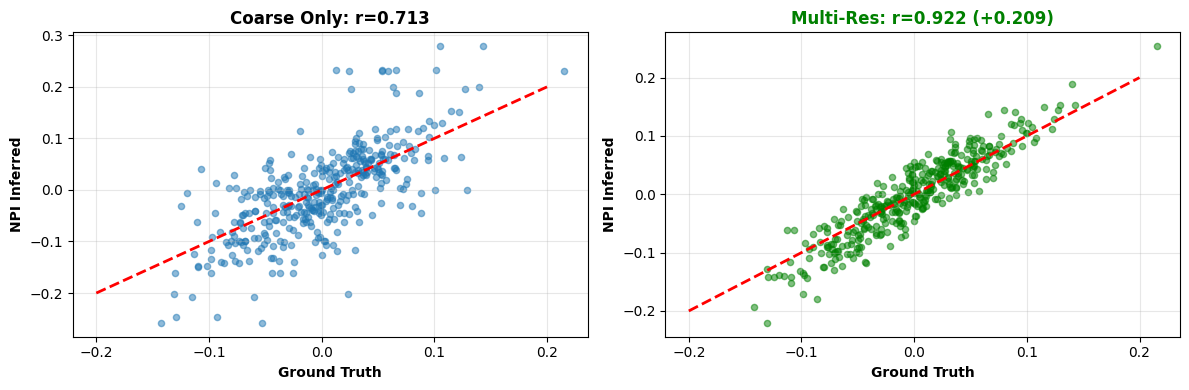

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(flat_without_diagonal(real_EC_smooth), flat_without_diagonal(EC_expanded), alpha=0.5, s=20)
axes[0].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[0].set_xlabel('Ground Truth', fontweight='bold')
axes[0].set_ylabel('NPI Inferred', fontweight='bold')
axes[0].set_title(f'Coarse Only: r={r_coarse:.3f}', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(flat_without_diagonal(real_EC_smooth), flat_without_diagonal(EC_multi_fine), alpha=0.5, s=20, color='green')
axes[1].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[1].set_xlabel('Ground Truth', fontweight='bold')
axes[1].set_ylabel('NPI Inferred', fontweight='bold')
axes[1].set_title(f'Multi-Res: r={r_multi:.3f} (+{r_multi-r_coarse:.3f})', fontweight='bold', color='green')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Alternative Training: Masking

In [26]:
inputs_tensor = torch.FloatTensor(inputs)
targets_tensor = torch.FloatTensor(targets)

ANN_masked = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_masked, train_loss_mask, test_loss_mask = train_with_masking(
    ANN_masked, inputs_tensor, targets_tensor, batch_size, train_set_proportion,
    num_epochs=100, lr=2.5e-4, l2=5e-5, mask_ratio=0.15
)

EC_masked = NPI.model_EC(ANN_masked, inputs_tensor, targets_tensor, pert_strength=1.0)
np.fill_diagonal(EC_masked, 0)

r_mask, _ = pearsonr(flat_without_diagonal(EC_masked), flat_without_diagonal(real_EC))
print(f'Masking: r = {r_mask:.3f}')

/content/npi_enhanced.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(input_X[:int(train_set_proportion * input_X.shape[0])], dtype=torch.float).to(device)
/content/npi_enhanced.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(target_Y[:int(train_set_proportion * target_Y.shape[0])], dtype=torch.float).to(device)
/content/npi_enhanced.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(input_X[int(train_set_proportion * input_X.shape[0]):], dtype

Masking: r = 0.906


## 5. Combined (SNR + Smoothing)

In [27]:
signals_combined = np.loadtxt('/content/combined_seed03_signal.txt')
real_EC_combined = np.loadtxt('/content/combined_seed03_real_EC.txt')
SNR_combined = np.loadtxt('/content/combined_seed03_SNR.txt')

inputs_comb, targets_comb = NPI.multi2one(signals_combined, steps=using_steps)
inputs_comb_tensor = torch.FloatTensor(inputs_comb)
targets_comb_tensor = torch.FloatTensor(targets_comb)

In [28]:
ANN_combined = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_combined, _, _ = train_with_snr_weights(
    ANN_combined, inputs_comb_tensor, targets_comb_tensor, SNR_combined,
    batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5,
    weight_strategy='log', weight_strength=0.3
)

EC_combined = NPI.model_EC(ANN_combined, inputs_comb_tensor, targets_comb_tensor, pert_strength=1.0)
EC_combined = compute_confidence_weighted_EC(EC_combined, SNR_combined)
np.fill_diagonal(EC_combined, 0)

r_comb, _ = pearsonr(flat_without_diagonal(EC_combined), flat_without_diagonal(real_EC_combined))
print(f'Combined : r = {r_comb:.3f}')

Combined : r = 0.814


In [33]:
results = {
    'Baseline': r_base,
    'Hetero SNR (Std)': r_std,
    'Hetero SNR (Weighted)': r_weighted,
    'Spatial (Coarse)': r_coarse,
    'Spatial (Multi-res)': r_multi,
    'Masking': r_mask,
    'Combined': r_comb
}
for name, r in results.items():
    star = '★' if r > r_base else ''
    print(f'{name:25s}: r = {r:.3f}')

Baseline                 : r = 0.912
Hetero SNR (Std)         : r = 0.886
Hetero SNR (Weighted)    : r = 0.878
Spatial (Coarse)         : r = 0.713
Spatial (Multi-res)      : r = 0.922
Masking                  : r = 0.906
Combined                 : r = 0.814


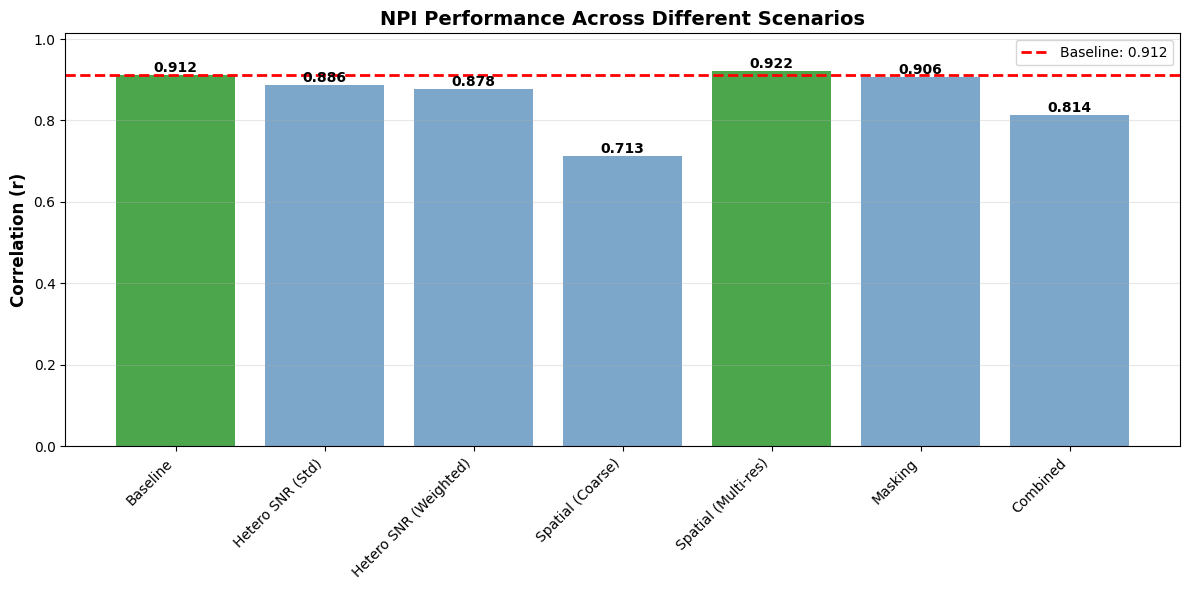

In [34]:
plt.figure(figsize=(12, 6))
names = list(results.keys())
values = list(results.values())
colors = ['steelblue' if v < r_base else 'green' for v in values]

bars = plt.bar(names, values, color=colors, alpha=0.7)
plt.axhline(y=r_base, color='red', linestyle='--', linewidth=2, label=f'Baseline: {r_base:.3f}')
plt.ylabel('Correlation (r)', fontweight='bold', fontsize=12)
plt.title('NPI Performance Across Different Scenarios', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, max(values) * 1.1])
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar, v in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()